# **Demo Mask R-CNN with COCO dataset**

## Connect to drive

In [ ]:
%cd ..
from google.colab import drive
drive.mount('content/gdrive')

/
Mounted at content/gdrive


In [ ]:
!ln -s /content/gdrive/My\ Drive/ /colab

In [ ]:
cd /colab/TrainPBL-customData

/content/gdrive/My Drive/TrainPBL-customData


## Set up evironment

In [ ]:
%%capture
# Install PyTorch with CUDA 11.8
# %pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchtext==0.14.1 torchaudio==0.13.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu117
!pip install torch==1.13.1+cu118 torchvision==0.14.1+cu118 torchaudio==0.13.1+cu118 --index-url https://download.pytorch.org/whl/cu118

# Install additional dependencies
!pip install matplotlib pandas pillow torchtnt==0.2.0 tqdm tabulate

# Install package for creating visually distinct colormaps
!pip install distinctipy

# Install utility packages
!pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

In [ ]:
!pip install pycocotools

## Importing the Required Dependencies

In [ ]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Import tqdm for progress bar
from tqdm.auto import tqdm
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image, ImageDraw
from torchvision.transforms.v2.functional import to_tensor, to_pil_image

In [ ]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

## Setting the Model Paths

In [ ]:
!pwd

/content/gdrive/MyDrive/TrainPBL-customData


In [ ]:
# /content/gdrive/MyDrive/TrainPBL-customData/pytorch-mask-r-cnn-instance-segmentation-custom-data/2024-06-09_05-23-18/maskrcnn_resnet50_fpn_v2.pth
model_path = './pytorch-mask-r-cnn-instance-segmentation-custom-data/2024-06-09_05-23-18/maskrcnn_resnet50_fpn_v2.pth'

## Define a function to convert segmentation polygons to images

In [ ]:
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)

    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

## Set up Class name

In [ ]:
# Danh sách các nhãn lớp
labels = [
    'background', 'dog', 'potted plant', 'tv', 'bird', 'cat', 'horse', 'sheep', 'cow', 'bottle', 'couch', 'chair', 'dining table',
    'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'boat', 'person', 'stop sign', 'umbrella', 'tie', 'sandwich',
    'bed', 'cell phone', 'refrigerator', 'clock', 'toothbrush', 'truck', 'traffic light', 'fire hydrant', 'parking meter',
    'bench', 'frisbee', 'skis', 'snowboard', 'skateboard', 'surfboard', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'orange', 'broccoli', 'carrot', 'pizza', 'cake', 'toilet', 'laptop', 'mouse', 'remote', 'keyboard',
    'microwave', 'oven', 'toaster', 'sink', 'book', 'vase', 'scissors', 'teddy bear', 'hair drier', 'backpack', 'handbag',
    'suitcase', 'elephant', 'zebra', 'kite', 'hot dog', 'donut', 'giraffe', 'baseball bat', 'baseball glove', 'sports ball',
    'bear', 'tennis racket'
]

# Tạo DataFrame từ danh sách các nhãn lớp
temp_df = pd.DataFrame(labels, columns=["Class Names"])

# Chuyển đổi DataFrame thành danh sách và thêm nhãn 'background'
class_names = temp_df["Class Names"].tolist()

# Hiển thị các nhãn lớp để kiểm tra
print(pd.DataFrame(class_names, columns=["Class Names"]))

       Class Names
0       background
1              dog
2     potted plant
3               tv
4             bird
5              cat
6            horse
7            sheep
8              cow
9           bottle
10           couch
11           chair
12    dining table
13         bicycle
14             car
15      motorcycle
16        airplane
17             bus
18           train
19            boat
20          person
21       stop sign
22        umbrella
23             tie
24        sandwich
25             bed
26      cell phone
27    refrigerator
28           clock
29      toothbrush
30           truck
31   traffic light
32    fire hydrant
33   parking meter
34           bench
35         frisbee
36            skis
37       snowboard
38      skateboard
39       surfboard
40      wine glass
41             cup
42            fork
43           knife
44           spoon
45            bowl
46          banana
47           apple
48          orange
49        broccoli
50          carrot
51          

## Loading the Mask R-CNN Model

In [ ]:
# Initialize the Mask R-CNN model with pretrained weights
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Get the number of input features for the classifier and mask predictor
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the number of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(class_names))

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(class_names))

# Set the model's device and data type
model.to(device=device, dtype=dtype)

# Load the model state from the file
model.load_state_dict(torch.load(model_path, map_location=device))

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:01<00:00, 109MB/s]


In [ ]:
test_inp = torch.randn(1, 3, 256, 256).to(device)

summary_df = markdown_to_pandas(f"{get_module_summary(model.eval(), [test_inp])}")

# # Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[summary_df.index == 0]

summary_df.drop(['In size', 'Out size', 'Contains Uninitialized Parameters?'], axis=1)

/usr/local/lib/python3.10/dist-packages/torchtnt/utils/module_summary.py:271: UserWarning: Backward FLOPs are only computed if module foward returns a tensor.
  warnings.warn(


,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs
0,MaskRCNN,46.3 M,46.1 M,185 M,285 G


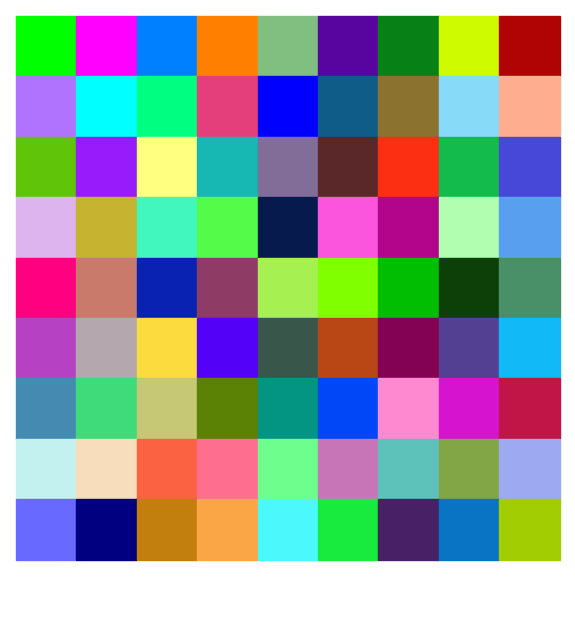

In [ ]:
# 80 class
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

In [ ]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


In [ ]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

## Input image

In [ ]:
sample_img = Image.open("/content/gdrive/MyDrive/TrainPBL-customData/coco/img_test/my-input-image.jpg").convert('RGB')

## Predict

In [ ]:
# Set the model to evaluation mode
model.eval();

# Ensure the model and input data are on the same device
model.to(device)
input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(sample_img)[None].to(device)

# Make a prediction with the model
with torch.no_grad():
    model_output = model(input_tensor)

In [ ]:
# Set the confidence threshold
threshold = 0.5

# Move model output to the CPU
model_output = move_data_to_device(model_output, 'cpu')

# Filter the output based on the confidence threshold
scores_mask = model_output[0]['scores'] > threshold
# Scale the predicted bounding boxes
pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask], format='xyxy', canvas_size=sample_img.size[::-1])
# Get the class names for the predicted label indices
pred_labels = [class_names[int(label)] for label in model_output[0]['labels'][scores_mask]]

# Extract the confidence scores
pred_scores = model_output[0]['scores']


# Convert masks to boolean after resizing
# Scale and stack the predicted segmentation masks
pred_masks = transforms.functional.resize(model_output[0]['masks'][scores_mask].unsqueeze(0), size=sample_img.size[::-1]).squeeze(0) # Resize masks
pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])


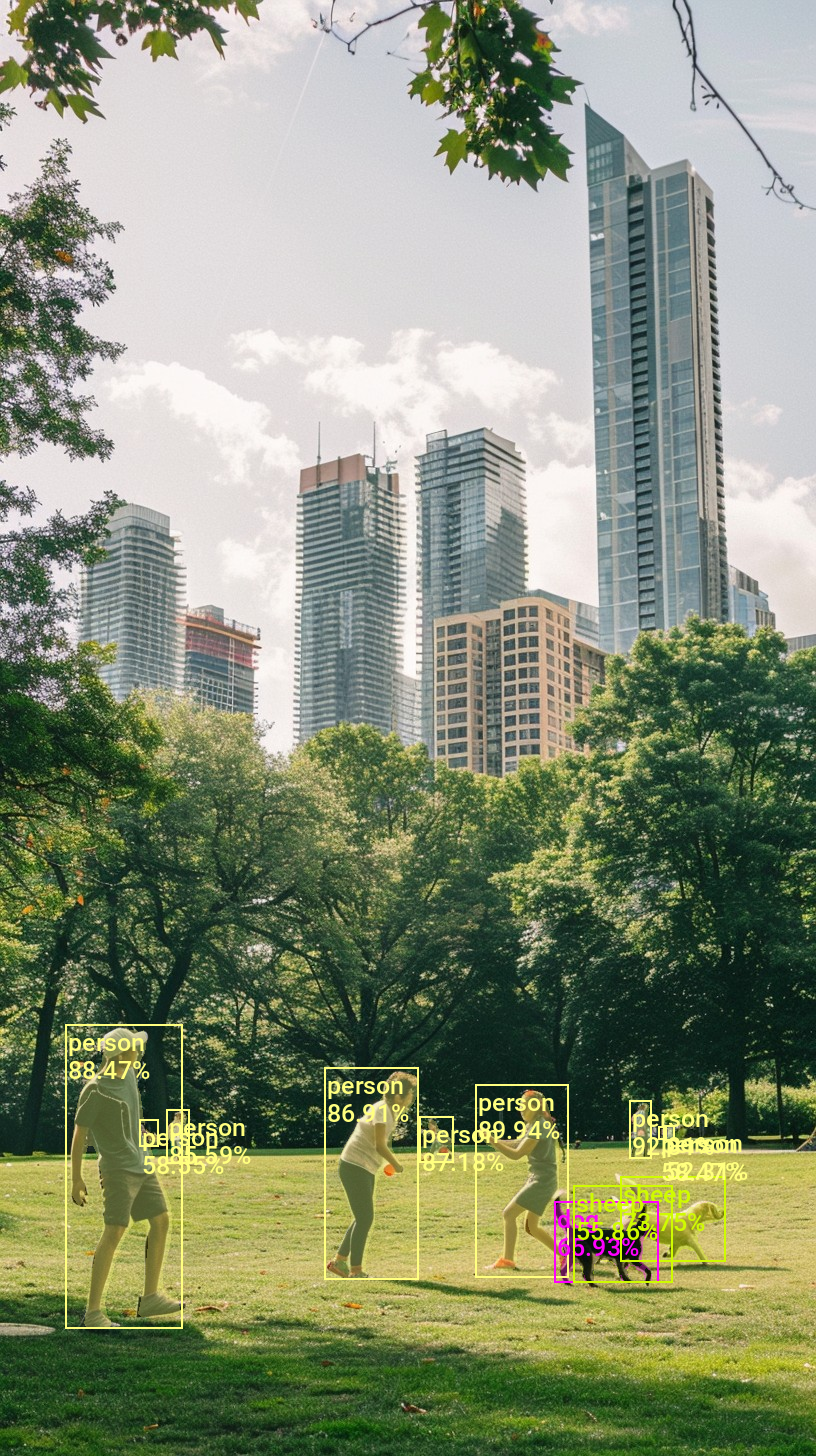

Confidence Scores:,"['person: 92.81%', 'person: 89.94%', 'person: 88.47%', 'person: 87.18%', 'person: 86.91%', 'person: 85.59%', 'sheep: 73.75%', 'dog: 65.93%', 'person: 58.55%', 'person: 58.47%', 'sheep: 55.86%', 'person: 52.31%']"


In [ ]:
# Set the model to evaluation mode
model.eval();

# Ensure the model and input data are on the same device
model.to(device)
input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(sample_img)[None].to(device)

# Make a prediction with the model
with torch.no_grad():
    model_output = model(input_tensor)
# Set the confidence threshold
threshold = 0.5

# Move model output to the CPU
model_output = move_data_to_device(model_output, 'cpu')

# Filter the output based on the confidence threshold
scores_mask = model_output[0]['scores'] > threshold
# Scale the predicted bounding boxes
pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask], format='xyxy', canvas_size=sample_img.size[::-1])
# Get the class names for the predicted label indices
pred_labels = [class_names[int(label)] for label in model_output[0]['labels'][scores_mask]]

# Extract the confidence scores
pred_scores = model_output[0]['scores']


# Convert masks to boolean after resizing
# Scale and stack the predicted segmentation masks
pred_masks = transforms.functional.resize(model_output[0]['masks'][scores_mask].unsqueeze(0), size=sample_img.size[::-1]).squeeze(0) # Resize masks
pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])
img_tensor = transforms.PILToTensor()(sample_img)
pred_colors=[int_colors[i] for i in [class_names.index(label) for label in pred_labels]]
# Annotate the test image with the predicted segmentation masks
annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=pred_masks, alpha=0.3, colors=pred_colors)
# Annotate the test image with the predicted labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=pred_bboxes,
    labels=[f"{label}\n{prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)],
    colors=pred_colors
)

# Display the annotated test image with the predicted bounding boxes
display( tensor_to_pil(annotated_tensor))
# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    # "Target BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(target_labels, np.round(target_bboxes.numpy(), decimals=3))],
    #"Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(pred_labels, pred_bboxes.round(decimals=3).numpy())],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)]
}).to_frame().style.hide(axis='columns')